In [1]:
import os
import struct
import numpy as np
from scipy.special import expit
import sys
import matplotlib.pyplot as plt

In [2]:
# функция для загрузки датасета
def load_weapon(path, kind='train'):
    
    labels_path = os.path.join(path, 
                               '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, 
                               '%s-images-idx3-ubyte' % kind)
          
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', 
                                 lbpath.read(8))
        labels = np.fromfile(lbpath, 
                             dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", 
                                               imgpath.read(16))
        images = np.fromfile(imgpath, 
                             dtype=np.uint8).reshape(len(labels), 12288)
 
    return images, labels

X_data, y_data = load_weapon('weapon', kind='train')
print('Rows: %d,  Columns: %d' % (X_data.shape[0], X_data.shape[1]))
X_test, y_test = load_weapon('weapon', kind='test')
print('Rows: %d,  Columns: %d' % (X_test.shape[0], X_test.shape[1]))

# датасет здесь делится на тренировочный и валидационный набор
X_train, y_train = X_data[:1200,:], y_data[:1200]
X_valid, y_valid = X_data[1200:,:], y_data[1200:]

print('Training:   ', X_train.shape, y_train.shape)
print('Validation: ', X_valid.shape, y_valid.shape)
print('Test Set:   ', X_test.shape, y_test.shape)

Rows: 1416,  Columns: 12288
Rows: 219,  Columns: 12288
Training:    (1200, 12288) (1200,)
Validation:  (216, 12288) (216,)
Test Set:    (219, 12288) (219,)


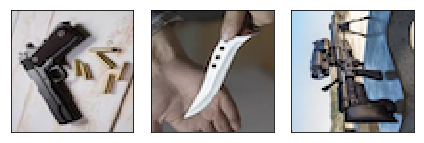

In [3]:
# визуализация изображений из 3-х классов
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(3):
    img = X_train[y_train == i][0].reshape(64, 64, 3)
    ax[i].imshow(img, cmap='brg', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

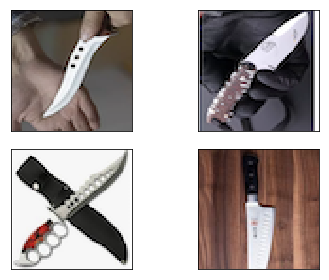

In [4]:
# визуализация изображений из класса "нож"
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(4):
    img = X_train[y_train == 1][i].reshape(64, 64, 3)
    ax[i].imshow(img, cmap='brg', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [5]:
# Реализация многойслойного персептрона (всего 3 слоя:
# 1-входной слой, 2-скрытый, 3-выходной слой)

class NeuralNetMLP(object):
    # определяю параметры сети
    def __init__(self, n_output, n_features, n_hidden=100,
                 l1=0.0, l2=0.0, epochs=500, eta=0.001,
                 alpha=0.0, decrease_const=0.0, shuffle=True,
                 minibatches=1, random_state=None):

        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches

    def _encode_labels(self, y, k):
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot

    def _initialize_weights(self):
        w1 = np.random.uniform(-1.0, 1.0,
                               size=self.n_hidden*(self.n_features + 1))
        w1 = w1.reshape(self.n_hidden, self.n_features + 1)
        w2 = np.random.uniform(-1.0, 1.0,
                               size=self.n_output*(self.n_hidden + 1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        return w1, w2

    def _sigmoid(self, z):
        # вернуть 1.0 / (1.0 + np.exp(-z))
        return expit(z)

    def _sigmoid_gradient(self, z):
        sg = self._sigmoid(z)
        return sg * (1 - sg)

    def _add_bias_unit(self, X, how='column'):
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1]+1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0]+1, X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('`how` должен быть `column` либо `row`')
        return X_new

    # прямое распространение ошибки
    def _feedforward(self, X, w1, w2):
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3

    # функция регуляризации
    def _L2_reg(self, lambda_, w1, w2):
        """Вычислить L2-регуляризованную стоимость"""
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2) +
                                np.sum(w2[:, 1:] ** 2))

    def _L1_reg(self, lambda_, w1, w2):
        """Вычислить L1-регуляризованную стоимость"""
        return (lambda_/2.0) * (np.abs(w1[:, 1:]).sum() +
                                np.abs(w2[:, 1:]).sum())

    # функция ошибки (функция стоимости с регуляризацией)
    def _get_cost(self, y_enc, output, w1, w2):
      
        term1 = -y_enc * (np.log(output))
        term2 = (1 - y_enc) * np.log(1 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost

    # расчёт градиента
    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
  
        # обратное распространение
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)

        # регуляризовать
        grad1[:, 1:] += (w1[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += (w2[:, 1:] * (self.l1 + self.l2))

        return grad1, grad2

    def predict(self, X):
        # дополнительное условие на случай ошибки с классом
        if len(X.shape) != 2:
            raise AttributeError('X должен быть массивом [n_samples, n_features].\n'
                                 'Используйте X[:,None] для 1-признаковой классификации,'
                                 '\nлибо X[[i]] для 1-выборочной классификации')

        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0)
        return y_pred

    def fit(self, X, y, print_progress=False):
     
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)

        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)

        epoch_strlen = len(str(self.epochs))  # for progress formatting
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}
        
        for i in range(self.epochs):

            # адаптивный темп обучения
            self.eta /= (1 + self.decrease_const*i)

            if print_progress:
                sys.stderr.write('\rЭпоха: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()

            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]

            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            
            for idx in mini:

                # прямое распространение 
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx],
                                                       self.w1,
                                                       self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx],
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
                self.cost_.append(cost)

                # вычислить градиент методом обратного распространения
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2,
                                                  a3=a3, z2=z2,
                                                  y_enc=y_enc[:, idx],
                                                  w1=self.w1,
                                                  w2=self.w2)
                # обновить веса
                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2
    
            # Evaluation (оценка качества тренировки и тестирования)
            a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
                
            cost = self._get_cost(y_enc=y_enc,
                                      output=a3,
                                      w1=self.w1,
                                      w2=self.w2)
            
            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                             '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

In [8]:
# параметры сети для обучения
nn = NeuralNetMLP(n_output=3,
                  n_features=X_train.shape[1],
                  n_hidden=1000,
                  l2=0.01,
                  l1=0.00,
                  epochs=50,
                  eta=0.001,
                  alpha=0.001,
                  decrease_const=0.00001,
                  minibatches=50,
                  shuffle=True,
                  random_state=1)

In [9]:
nn.fit(X_train, y_train, print_progress=True)

50/50 | Cost: 23863.61 | Train/Valid Acc.: 64.08%/52.31% 

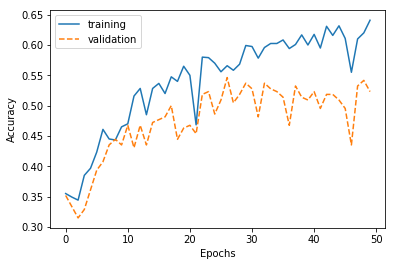

In [10]:
# визуализация метрик обучения и валидации
plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [13]:
batches = np.array_split(range(len(nn.cost_)), 50)
cost_ary = np.array(nn.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]

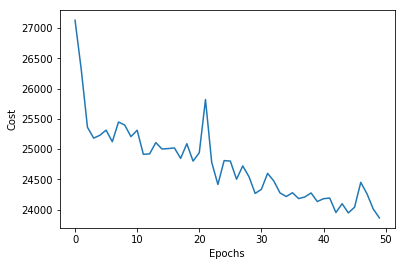

In [14]:
# визуализации функции стоимости по итогам эпох
plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

In [15]:
import sys

y_train_pred = nn.predict(X_train)

if sys.version_info < (3, 0):
    acc = (np.sum(y_train == y_train_pred, axis=0)).astype('float') / X_train.shape[0]
else:
    acc = np.sum(y_train == y_train_pred, axis=0) / X_train.shape[0]

print('Точность на тренировочном наборе: %.2f%%' % (acc * 100))

Точность на тренировочном наборе: 64.08%


In [16]:
y_test_pred = nn.predict(X_test)

if sys.version_info < (3, 0):
    acc = (np.sum(y_test == y_test_pred, axis=0)).astype('float') / X_test.shape[0]
else:
    acc = np.sum(y_test == y_test_pred, axis=0) / X_test.shape[0]

print('Точность на тестовом наборе: %.2f%%' % (acc * 100))

Точность на тестовом наборе: 57.08%


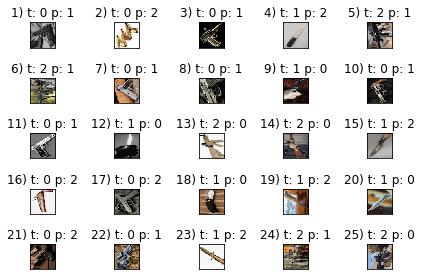

In [17]:
# часть неправильно классифицированных тестовых изображений
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab= y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(64, 64, 3)
    ax[i].imshow(img, cmap='brg', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()